In [ ]:
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from matplotlib import pyplot as plt


def adjust_gamma(image, gamma=1.2):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, table)

def preprocess_image(image, augment=False):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(gray_image)

    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened_image = cv2.filter2D(clahe_image, -1, kernel)

    preprocessed_image = adjust_gamma(sharpened_image, gamma=1.2)

    if augment:
        flipped_image = cv2.flip(preprocessed_image, 1) 
        return [preprocessed_image, flipped_image]

    return preprocessed_image

def extract_descriptors(image):
    sift = cv2.SIFT_create()
    orb = cv2.ORB_create()

    sift_descriptors = sift.detectAndCompute(image, None)[1]
    orb_descriptors = orb.detectAndCompute(image, None)[1]

    if sift_descriptors is not None and orb_descriptors is not None:
        return np.vstack((sift_descriptors, orb_descriptors))
    return sift_descriptors if sift_descriptors is not None else orb_descriptors

def extract_deep_features(image, model):
    """Extract deep features using a pre-trained ResNet50 model."""
    resized_image = cv2.resize(image, (224, 224))

    if len(resized_image.shape) == 2 or resized_image.shape[2] == 1:
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)

    image_array = img_to_array(resized_image)
    image_array = np.expand_dims(image_array, axis=0)
    image_array = preprocess_input(image_array)
    features = model.predict(image_array)
    return features.flatten()


def collect_descriptors(data_dir, label_map, augment=False, use_deep_features=False, model=None):
    """Collect SIFT, ORB, or deep descriptors from images."""
    descriptors_list = []
    labels = []

    for label_name in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_name)

        if not os.path.isdir(label_path):
            continue

        label_idx = label_map.get(label_name)
        if label_idx is None:
            print(f"Label '{label_name}' not found in label_map. Skipping...")
            continue

        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Failed to load image: {image_path}")
                continue

            processed_images = preprocess_image(image, augment=augment)
            if not isinstance(processed_images, list):
                processed_images = [processed_images]

            for img in processed_images:
                if use_deep_features and model:
                    features = extract_deep_features(img, model)
                    if features is not None:
                        descriptors_list.append(features)
                    else:
                        print(f"Failed to extract deep features for image: {image_path}")
                else:
                    descriptors = extract_descriptors(img)
                    if descriptors is not None:
                        descriptors_list.append(descriptors)
                    else:
                        print(f"No descriptors found for image: {image_path}")

                labels.append(label_idx)

    return descriptors_list, labels

def train_and_evaluate(X, y):
    scaler = RobustScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    param_grid = {
        'n_estimators': [1500, 2000],
        'max_depth': [30, 50, None],
        'max_features': ['sqrt', 'log2']
    }
    classifier = GridSearchCV(RandomForestClassifier(class_weight="balanced", random_state=42),
                              param_grid, cv=3, n_jobs=-1, verbose=1)
    classifier.fit(X_train, y_train)


    best_rf = classifier.best_estimator_
    print(f"Best Parameters: {classifier.best_params_}")

    # Evaluate accuracy
    y_pred = best_rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return best_rf

if __name__ == "__main__":
    label_map = {'angry': 0, 'happy': 1, 'sad': 2}
    train_data_dir = r'C:\Users\me\Desktop\Recognition\training'


    resnet_model = ResNet50(weights="imagenet", include_top=False, pooling="avg")


    descriptors, labels = collect_descriptors(train_data_dir, label_map, augment=True, use_deep_features=True, model=resnet_model)


    if descriptors:
        print(f"Number of descriptors extracted: {len(descriptors)}")
        print(f"Shape of the first descriptor: {descriptors[0].shape if len(descriptors) > 0 else 'N/A'}")
        print(f"Labels: {labels}")
    else:
        print("No descriptors were extracted. Check the dataset or preprocessing steps.")


    try:
        train_and_evaluate(np.array(descriptors), labels)
    except ValueError as e:
        print(f"Error during training: {e}. Ensure descriptors and labels are consistent.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Number of descriptors extracted: 924

Shape of the first descriptor: (2048,)

Accuracy:72% for random forset classifier

Saved Original Image to C:\Users\me\Desktop\Recognition\output\Original Image.png
Saved CLAHE Processed Image to C:\Users\me\Desktop\Recognition\output\CLAHE Processed Image.png
Saved Final Processed Image to C:\Users\me\Desktop\Recognition\output\Final Processed Image.png


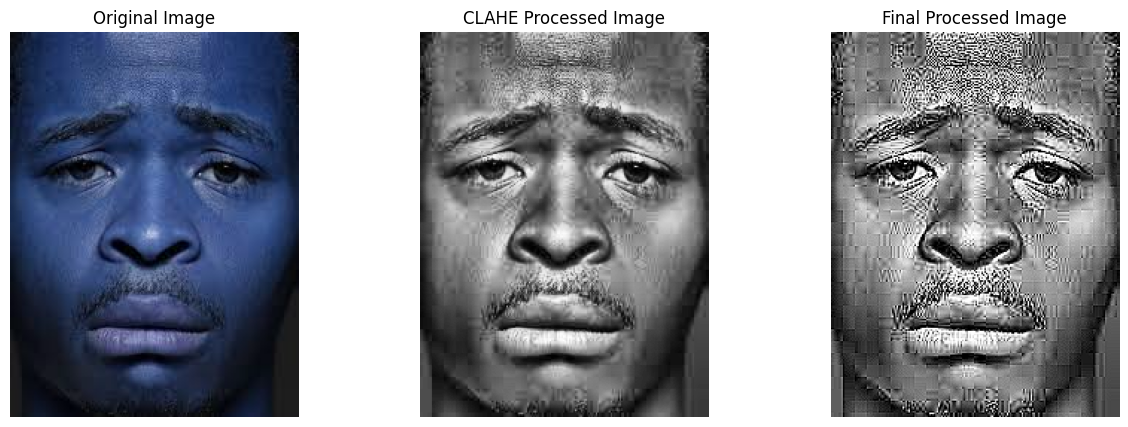

In [21]:

import os
import cv2
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import img_to_array
from matplotlib import pyplot as plt

def adjust_gamma(image, gamma=1.2):
    """Apply gamma correction to adjust brightness."""
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, table)

def preprocess_image(image, augment=False):
    """Preprocess image with CLAHE, sharpening, and augmentation."""
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(gray_image)

    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened_image = cv2.filter2D(clahe_image, -1, kernel)


    preprocessed_image = adjust_gamma(sharpened_image, gamma=1.2)


    if augment:
        flipped_image = cv2.flip(preprocessed_image, 1)
        return [preprocessed_image, flipped_image], clahe_image

    return preprocessed_image, clahe_image

def save_images(images, titles, folder_path):
    """Save images to the specified folder."""
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    for i, img in enumerate(images):
        file_path = os.path.join(folder_path, f"{titles[i]}.png")
        cv2.imwrite(file_path, img)
        print(f"Saved {titles[i]} to {file_path}")


if __name__ == "__main__":
    image_path = r'C:\Users\me\Desktop\Recognition\training\sad image.jpeg'
    image = cv2.imread(image_path)

    if image is None:
        print("Failed to load image.")
    else:

        processed_image, clahe_image = preprocess_image(image)


        save_folder = r'C:\Users\me\Desktop\Recognition\output'


        save_images(
            [image, clahe_image, processed_image],
            ["Original Image", "CLAHE Processed Image", "Final Processed Image"],
            save_folder
        )

        
        display_images(
            [image, clahe_image, processed_image],
            ["Original Image", "CLAHE Processed Image", "Final Processed Image"]
        )
